In [1]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
# import tensorflow as tf

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from random import randint

# from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow import keras

neuronet_model = keras.models.load_model('./saved_neuronet_model/model_6')


In [3]:
neuronet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               1280      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,620
Trainable params: 9,601
Non-trainable params: 19
_____________________________________________________

**Загрузка данных**

In [4]:
url = "./data_count_exercise_test.csv"
data_workout_exercises = pd.read_csv(url)
# del data_workout_exercises['Unnamed: 0']

In [5]:
data_workout_exercises['target_count'] += np.random.randint(-2, 3, size=data_workout_exercises['target_count'].shape[0])
data_workout_exercises.head()


,id_exercise,push_ups,running_3km,squats,press,pull_ups,id_gender,age,feeling,target_count
0,13,11,15.805354,66,51,4,1,26,1,3
1,19,46,12.847877,96,1,13,1,43,1,28
2,14,34,21.357448,28,26,1,2,30,1,9
3,20,36,16.219366,58,33,12,2,29,2,14
4,1,80,9.338186,2,15,2,2,19,2,32


In [6]:
data_workout_exercises['target_count'].where(
    ~(data_workout_exercises.target_count < 0),
    other=0,
    inplace=True
    )
# for ids in sorted(data_workout_exercises['id_exercise'].unique()):
#     df = data_workout_exercises.loc[data_workout_exercises['id_exercise'] == ids]
#     print('Упражнение id:', ids)
#     print('Среднее количество повторений женщины:', df.loc[df['id_gender'] == 2][['target_count']].mean())
#     print('Среднее количество повторений мужчины:', df.loc[df['id_gender'] == 1][['target_count']].mean())
#     print('Макс. кол-во повторений:', df['target_count'].max())
#     print('Мин. кол-во повторений:', df['target_count'].min())
#     print()

In [8]:
# data_workout_exercises.isna().sum()

In [7]:
# dataset = data_workout_exercises.dropna()

# Разделяем данные на тренировочные и тестовые
train_dataset = data_workout_exercises.sample(frac=0.8, random_state=0)
test_dataset = data_workout_exercises.drop(train_dataset.index)

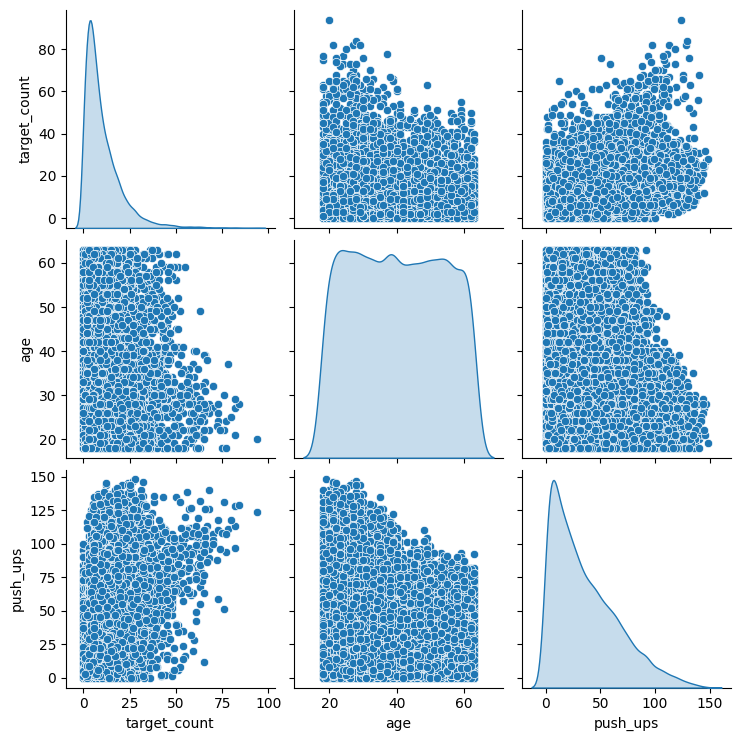

In [9]:
sns.pairplot(train_dataset[['target_count', 'age', 'push_ups']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id_exercise,16000.0,11.064375,6.107306,1.000000,6.000000,11.0000,16.000000,21.000000
push_ups,16000.0,36.010750,29.799835,0.000000,11.000000,28.0000,55.000000,148.000000
running_3km,16000.0,18.986974,5.501769,8.487284,14.813959,18.3507,22.529589,40.771989
squats,16000.0,37.086562,30.122847,0.000000,12.000000,30.0000,56.000000,147.000000
press,16000.0,24.292687,20.239852,0.000000,7.000000,19.0000,37.000000,98.000000
pull_ups,16000.0,6.192437,6.054488,0.000000,2.000000,4.0000,9.000000,36.000000
id_gender,16000.0,1.503250,0.500005,1.000000,1.000000,2.0000,2.000000,2.000000
age,16000.0,40.272500,13.264468,18.000000,29.000000,40.0000,52.000000,63.000000
feeling,16000.0,2.000250,0.816343,1.000000,1.000000,2.0000,3.000000,3.000000
target_count,16000.0,10.218563,9.997245,0.000000,3.000000,7.0000,14.000000,90.000000


<Axes: >

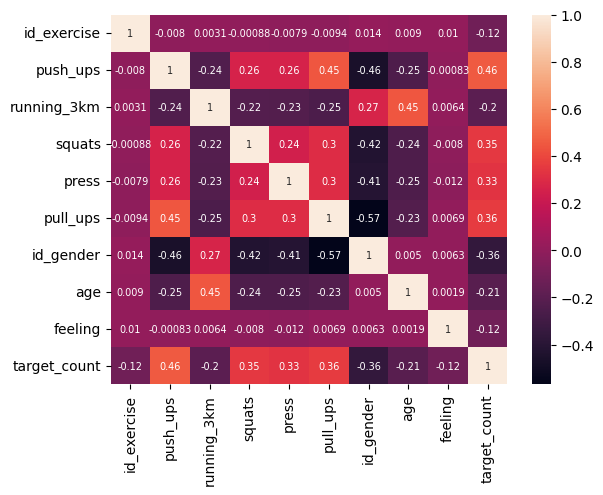

In [12]:
sns.heatmap(data_workout_exercises.corr(), annot=True, annot_kws={"size": 7})

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target_count')
test_labels = test_features.pop('target_count')

In [14]:
test_features[:1].shape

(1, 9)

**Нормализация**

In [15]:
normalizer = Normalization(axis=-1)

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[[11.064376  36.01074   18.986977  37.08657   24.292696   6.1924357
   1.5032496 40.272556   2.0002508]]


**Создание модели**

In [18]:
linear_model = Sequential([
    normalizer,
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dense(1)
])

In [19]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 189ms/step


array([[-0.35101455],
       [-0.25988528],
       [-0.07043045],
       [-0.11651357],
       [ 0.28455675],
       [ 0.0141926 ],
       [-0.01431359],
       [-0.33327284],
       [ 0.10195142],
       [-0.08829425]], dtype=float32)

In [20]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 128) dtype=float32, numpy=
array([[-0.16713871, -0.00406668,  0.18310122, ...,  0.16143976,
         0.13425852, -0.07558182],
       [-0.0754448 ,  0.01134303, -0.13970056, ..., -0.1491684 ,
        -0.11696768,  0.03384401],
       [-0.12303214, -0.13291141, -0.11882461, ...,  0.15248166,
        -0.1614259 ,  0.1309297 ],
       ...,
       [-0.02571379, -0.15001366,  0.15394647, ..., -0.13484374,
        -0.02252722,  0.00088398],
       [-0.20261528, -0.1052401 , -0.20638467, ...,  0.01007661,
         0.17420112,  0.05886625],
       [ 0.15203042,  0.09782858, -0.16401705, ..., -0.10821408,
         0.08005585,  0.00821464]], dtype=float32)>

**Обучение**

In [21]:
linear_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_absolute_error')

In [22]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=1000,
    batch_size=64,
    # Suppress logging.
    # verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

Epoch 1/1000
200/200 [==============================] - 2s 3ms/step - loss: 6.0030 - val_loss: 5.2704
Epoch 2/1000
200/200 [==============================] - 0s 2ms/step - loss: 5.1444 - val_loss: 5.0895
Epoch 3/1000
200/200 [==============================] - 0s 2ms/step - loss: 5.0579 - val_loss: 5.0164
Epoch 4/1000
200/200 [==============================] - 0s 2ms/step - loss: 4.9549 - val_loss: 4.8988
Epoch 5/1000
200/200 [==============================] - 0s 2ms/step - loss: 4.8337 - val_loss: 4.7707
Epoch 6/1000
200/200 [==============================] - 0s 2ms/step - loss: 4.7068 - val_loss: 4.6166
Epoch 7/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.5827 - val_loss: 4.5297
Epoch 8/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.4741 - val_loss: 4.4389
Epoch 9/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.3923 - val_loss: 4.3311
Epoch 10/1000
200/200 [==============================] - 1s 3ms/step - loss: 4.331

**Проверка**

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,1.523120,1.552673,995
996,1.519186,1.569084,996
997,1.499642,1.565466,997
998,1.500339,1.530124,998
999,1.516843,1.572819,999


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

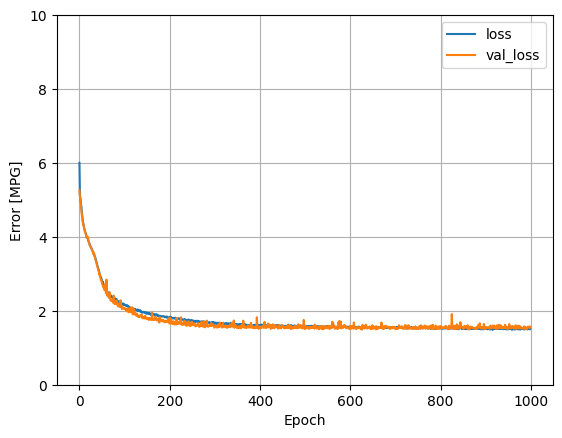

In [25]:
plot_loss(history)

In [26]:
from sklearn.metrics import r2_score
r2_score(test_labels, linear_model.predict(test_features), multioutput='variance_weighted')

125/125 [==============================] - 0s 1ms/step


0.9601376557758662

In [27]:
print(test_labels[:10], np.round(linear_model.predict(test_features[:10])), test_features[:10])

1/1 [==============================] - 0s 74ms/step
10     1
19     4
28     8
40    24
43     5
52     0
53     6
55     3
62     8
63     7
Name: target_count, dtype: int64 [[ 2.]
 [ 1.]
 [ 9.]
 [24.]
 [ 6.]
 [ 1.]
 [ 8.]
 [ 6.]
 [ 7.]
 [ 9.]]     id_exercise  push_ups  running_3km  squats  press  pull_ups  id_gender   
10            9        17    15.153845      27      9         1          2  \
19            9         0    14.312155       6     10         8          2   
28           17        54    17.135392      39     30         1          1   
40           19        98    10.962408      62      1        12          1   
43           10        31    13.413996      62     16         3          1   
52            7         1    12.632366       4      7         0          2   
53           18        24    20.448995      26      2         7          1   
55            8        24    16.094856      85     12         7          1   
62           20        30    18.875188       7     1

In [28]:
linear_model.save('saved_neuronet_model/model_6')

INFO:tensorflow:Assets written to: saved_neuronet_model/model_6\assets


INFO:tensorflow:Assets written to: saved_neuronet_model/model_6\assets


In [29]:
linear_model.save('saved_neuronet_model/model_6.h5')